In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [54]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [55]:
import torch

# Pastikan CUDA tersedia
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Pilih GPU pertama (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA GeForce GTX 1650


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
X, y = make_classification(n_samples=200, n_features=10, n_informative=8, n_redundant=2, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [60]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [61]:
# Function to create MLP model
def create_model(input_size, hidden_layers, activation_fn):
    layers = []
    last_size = input_size
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(last_size, hidden_size))
        layers.append(activation_fn())
        last_size = hidden_size
    layers.append(nn.Linear(last_size, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers).to(device)

In [62]:
# Parameters to compare
hidden_layer_configs = [[4], [8], [16], [32], [64], [128], [4, 8], [8, 16], [16, 32], [32, 64], [64, 128]]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.Identity]
epochs_list = [1, 10, 25, 50, 100, 250]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]

HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 16	 |Accuracy: 0.5750
HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 32	 |Accuracy: 0.4500
HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 64	 |Accuracy: 0.3000
HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 128	 |Accuracy: 0.6750
HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 256	 |Accuracy: 0.4750
HL: [4]	 | ReLU	| Epoch: 1	| LR: 10	 |Batch Size: 512	 |Accuracy: 0.4250
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 16	 |Accuracy: 0.4250
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 32	 |Accuracy: 0.3000
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 64	 |Accuracy: 0.3000
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 128	 |Accuracy: 0.7000
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 256	 |Accuracy: 0.4250
HL: [4]	 | ReLU	| Epoch: 1	| LR: 1	 |Batch Size: 512	 |Accuracy: 0.4000
HL: [4]	 | ReLU	| Epoch: 1	| LR: 0.1	 |Batch Size: 16	 |Accuracy: 0.5500
HL: [4]	 | ReLU	| Epoch: 1	| LR: 0.1	 |Batch Size: 32	 |Accurac

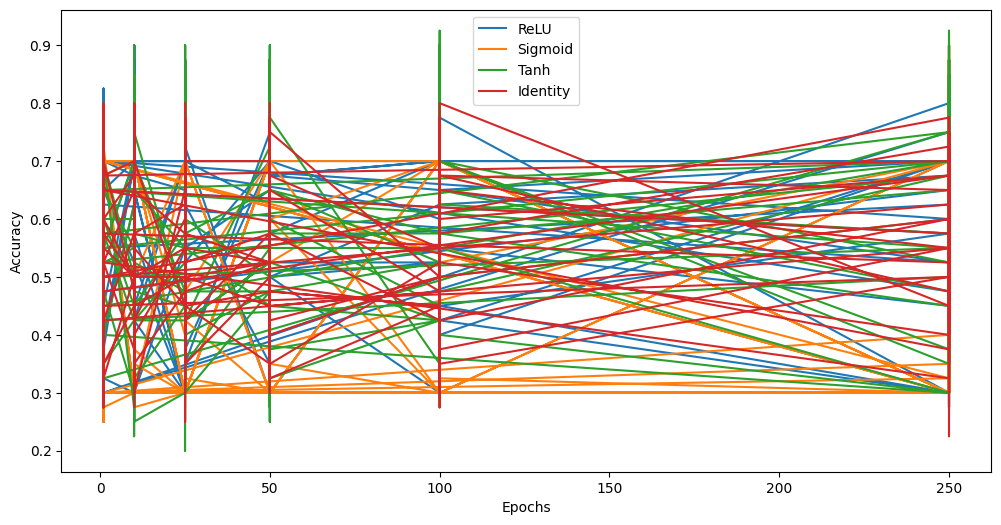

In [63]:
# Evaluate combinations
results = []
for hidden_layers in hidden_layer_configs:
    for activation_fn in activation_functions:
        for epochs in epochs_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    # Create model
                    model = create_model(X_train.shape[1], hidden_layers, activation_fn)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train model
                    model.train()
                    for epoch in range(epochs):
                        for batch_X, batch_y in train_loader:
                            optimizer.zero_grad()
                            outputs = model(batch_X)
                            loss = criterion(outputs, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Evaluate model
                    model.eval()
                    correct = 0
                    total = 0
                    with torch.no_grad():
                        for batch_X, batch_y in test_loader:
                            outputs = model(batch_X)
                            predicted = (outputs >= 0.5).float()
                            total += batch_y.size(0)
                            correct += (predicted == batch_y).sum().item()

                    accuracy = correct / total
                    results.append({
                        'hidden_layers': hidden_layers,
                        'activation_fn': activation_fn.__name__,
                        'epochs': epochs,
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'accuracy': accuracy
                    })
                    print(f"HL: {hidden_layers}\t | {activation_fn.__name__}\t| Epoch: {epochs}\t| LR: {lr}\t |Batch Size: {batch_size}\t |Accuracy: {accuracy:.4f}")

# Save results to CSV
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("Classification_Dummy.csv", index=False)

# Plotting results (example for one parameter comparison)
plt.figure(figsize=(12, 6))
for activation_fn in results_df['activation_fn'].unique():
    subset = results_df[results_df['activation_fn'] == activation_fn]
    plt.plot(subset['epochs'], subset['accuracy'], label=f"{activation_fn}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.read_csv('Classification_Dummy.csv')

results_df.head()

def plot_experiment_results(results_df, metric, title):
    plt.figure(figsize=(10, 6))
    results_df_sorted = results_df.sort_values(by=metric, ascending=False)
    plt.bar(results_df_sorted.index, results_df_sorted[metric], color='blue')
    plt.xlabel('Experiment Index')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.show()


C:\Users\ccoos\AppData\Local\Temp\ipykernel_6068\426543034.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5['group'] = top_5[grouping_columns].astype(str).agg('  |  '.join, axis=1)


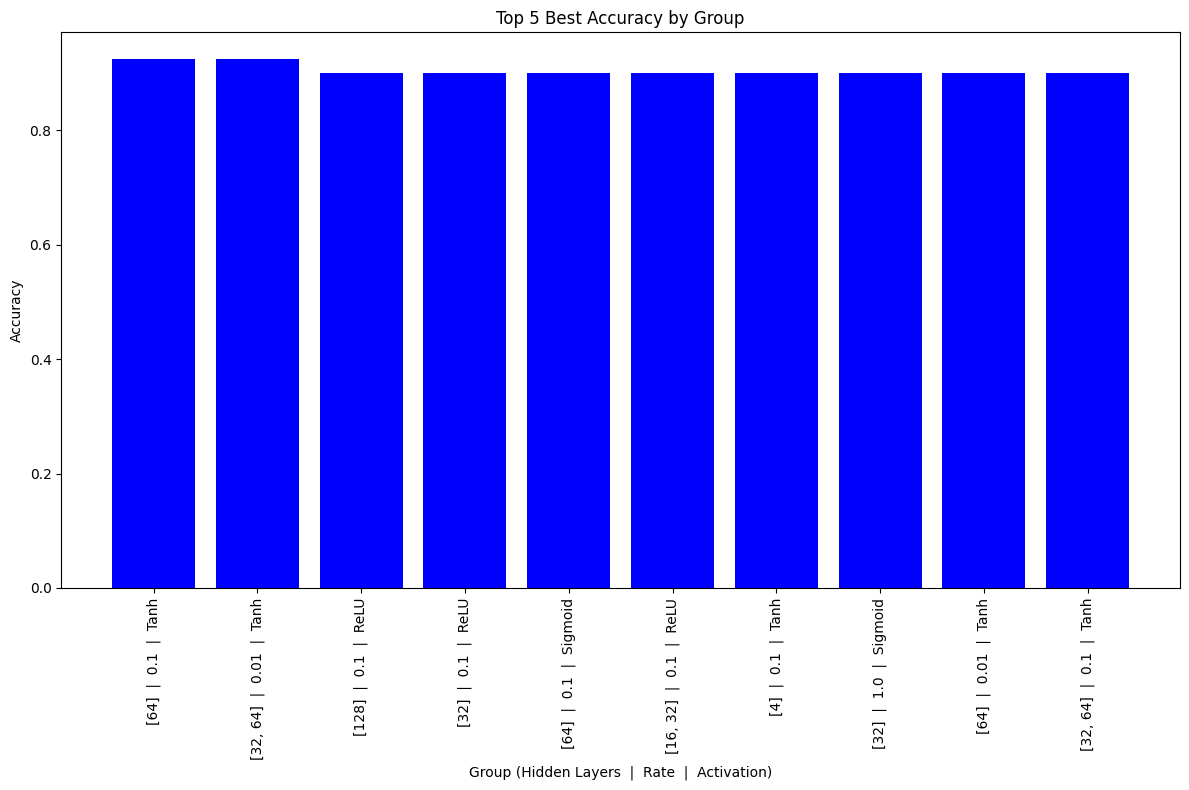

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_best_accuracy_by_group(results_df, grouping_columns, metric='accuracy', title='Best Accuracy by Group'):

    grouped = results_df.groupby(grouping_columns).agg({metric: 'max'}).reset_index()

    grouped_sorted = grouped.sort_values(by=metric, ascending=False)

    top_5 = grouped_sorted.head(10)

    top_5['group'] = top_5[grouping_columns].astype(str).agg('  |  '.join, axis=1)

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.bar(top_5['group'], top_5[metric], color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Group (Hidden Layers  |  Rate  |  Activation)')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.tight_layout()
    plt.show()

grouping_columns = ['hidden_layers', 'learning_rate', 'activation_fn']
plot_best_accuracy_by_group(results_df, grouping_columns, metric='accuracy', title='Top 5 Best Accuracy by Group')
